In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import wandb

import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx

import networkx as nx
from networkx.convert_matrix import from_numpy_array

import functions as f
from functions import dict_to_array, normalize_array
import models as m

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
os.environ['WANDB_NOTEBOOK_NAME']="GCN_2Class.ipynb"

In [3]:
# Loading the time series
time_series_list = f.load_time_series()
time_series_df_list = f.list_of_df_of_time_series(time_series_list)

In [4]:
# Loading the pearson correlation matrices
corr_matrix_list = f.corr_matrix_paths()['pearson']
print(corr_matrix_list)
# Example patient
path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[0]}'
corr_matrix_patient = np.loadtxt(path, delimiter=',')
print(corr_matrix_patient)

['patient_136_S_4517.csv', 'patient_130_S_4468.csv', 'patient_002_S_4654.csv', 'patient_002_S_4251.csv', 'patient_013_S_5171.csv', 'patient_130_S_2391.csv', 'patient_031_S_4947.csv', 'patient_100_S_5102.csv', 'patient_012_S_5121.csv', 'patient_053_S_5287.csv', 'patient_002_S_1261.csv', 'patient_018_S_4313.csv', 'patient_130_S_4641.csv', 'patient_012_S_4188.csv', 'patient_002_S_4521.csv', 'patient_130_S_4250.csv', 'patient_031_S_4005.csv', 'patient_130_S_5006.csv', 'patient_006_S_4363.csv', 'patient_012_S_4012.csv', 'patient_031_S_4149.csv', 'patient_031_S_4029.csv', 'patient_013_S_4917.csv', 'patient_129_S_4287.csv', 'patient_130_S_4730.csv', 'patient_129_S_0778.csv', 'patient_031_S_4203.csv', 'patient_013_S_4268.csv', 'patient_053_S_0919.csv', 'patient_002_S_4447.csv', 'patient_012_S_4987.csv', 'patient_018_S_4868.csv', 'patient_100_S_4556.csv', 'patient_100_S_5106.csv', 'patient_130_S_5175.csv', 'patient_130_S_4294.csv', 'patient_053_S_5296.csv', 'patient_031_S_4474.csv', 'patient_12

In [5]:
# Loading the diagnostic labels
diagnostic_label_all = np.loadtxt('ADNI_full/diagnostic_label.csv', dtype=str, delimiter=',')

In [6]:
def filter_group(group):
    df = pd.read_csv('ADNI_FULL/patient_info.csv')
    labels = df['Research Group']
    label_idx_list = [i for i in range(len(labels)) if labels[i] == group]
    return label_idx_list

In [7]:
#binary classification
cn = filter_group('CN')
ad = filter_group('AD')
bin_idx = sorted(cn + ad)
corr_matrices = [corr_matrix_list[i] for i in bin_idx]
diagnostic_label = [diagnostic_label_all[i] for i in bin_idx]
for i in range(len(diagnostic_label)):
    if diagnostic_label[i] == 'CN':
        diagnostic_label[i] = 0
    elif diagnostic_label[i] == 'AD':
        diagnostic_label[i] = 1
    else:
        print('Error: incorrect label')

In [8]:
assert len(diagnostic_label) == len(corr_matrices)

In [9]:
# Defining a class to preprocess raw data into a format suitable for training Graph Neural Networks (GNNs).
## With the possibility of assigning weight to edges, adding the age feature, sex feature, and matrixe profiling.

class Raw_to_Graph_2Class(InMemoryDataset):
    def __init__(self, root, threshold, method, weight=False, age=False, sex=False, matrixprofile=False, transform=None, pre_transform=None):
        self.threshold = threshold
        self.method = method
        self.weight = weight
        self.age = age
        self.sex = sex
        self.matrixprofile = matrixprofile
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        graphs=[]
        for patient_idx, patient_matrix in enumerate(corr_matrices):
            path = f'ADNI_full/corr_matrices/corr_matrix_{self.method}/{patient_matrix}'
            corr_matrix = np.loadtxt(path, delimiter=',')
            # Here ROIs stands for Regions of Interest
            nbr_ROIs = corr_matrix.shape[0]
            edge_matrix = np.zeros((nbr_ROIs,nbr_ROIs))
            for j in range(nbr_ROIs):
                for k in range(nbr_ROIs):
                    # Here we are using the absolute value of each element of the correlation matrix, as the corr coeff is in the range [-1,1].
                    if np.abs(corr_matrix[j,k]) < self.threshold:
                        edge_matrix[j,k] = 0
                    else:
                        if self.weight:
                            # Here we assign the absolute value of the correlation coefficient as the edge weight.
                            edge_matrix[j,k] = corr_matrix[j,k]
                        else:
                            # Here we assign 1 as the edge weight, i.e. regardless of the the absolute value of the correlation coefficient.
                            edge_matrix[j,k] = 1

            # Create a NetworkX graph from the edge matrix
            NetworkX_graph = from_numpy_array(edge_matrix)

            # Compute the degree, betweenness centrality, clustering coefficient, local efficiency for each node of the graph and the global efficiency of the graph
            degree_dict = dict(NetworkX_graph.degree())
            between_central_dict = nx.betweenness_centrality(NetworkX_graph)
            cluster_coeff_dict = nx.clustering(NetworkX_graph)
            global_eff = nx.global_efficiency(NetworkX_graph)
            local_eff_dict = {}
            for node in NetworkX_graph.nodes():
                subgraph_neighb = NetworkX_graph.subgraph(NetworkX_graph.neighbors(node))
                if subgraph_neighb.number_of_nodes() > 1:
                    efficiency = nx.global_efficiency(subgraph_neighb)
                else:
                    efficiency = 0.0
                local_eff_dict[node] = efficiency

            # Convert the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency dictionaries to NumPy arrays then normalize them
            degree_array = dict_to_array(degree_dict)
            degree_array_norm = normalize_array(degree_array)

            between_central_array = dict_to_array(between_central_dict)
            between_central_array_norm = normalize_array(between_central_array)

            local_efficiency_array = dict_to_array(local_eff_dict)
            local_eff_array_norm = normalize_array(local_efficiency_array)

            ratio_local_global_array = dict_to_array(local_eff_dict) / global_eff
            ratio_local_global_array_norm = normalize_array(ratio_local_global_array)

            cluster_coeff_array = dict_to_array(cluster_coeff_dict)
            cluster_coeff_array_norm = normalize_array(cluster_coeff_array)

            # Initializing an array for the graph features
            x_array = np.stack([degree_array_norm, between_central_array_norm, local_eff_array_norm, cluster_coeff_array_norm, ratio_local_global_array_norm], axis=-1)
            x_array = x_array.astype(np.float32)
            
            if self.matrixprofile:
                path = f'ADNI_full/matrix_profiles/matrix_profile_{self.method}/{patient_matrix}'
                with open(path, "rb") as fl:
                  patient_dict = pkl.load(fl)
                # combine dimensions
                features = np.array(patient_dict['mp']).reshape(len(patient_dict['mp']),-1)
                features = features.astype(np.float32)
                x_array = np.concatenate((x_array, features), axis=-1)

            # Concatenate the degree, participation coefficient, betweenness centrality, local efficiency, and ratio of local to global efficiency arrays to form a single feature vector
            x = torch.tensor(x_array, dtype=torch.float)

            # Create a Pytorch Geometric Data object from the NetworkX
            graph_data = from_networkx(NetworkX_graph)
            ## The feature matrix of the graph is the degree, betweenness centrality, local efficiency, clustering coefficient and ratio of local to global efficiency of each node
            graph_data.x = x
            ## The target/output variable that we want to predict is the diagnostic label of the patient
            graph_data.y = float(diagnostic_label[patient_idx])
            graphs.append(graph_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])


Dataset: Raw_to_Graph_2Class(78):
Number of graphs: 78
Weighted: True
Threshold: 0.5
Correlation Method: pearson
Number of features: 461
Number of classes: 2

Data(edge_index=[2, 1116], weight=[1116], x=[116, 461], y=[1], num_nodes=116)
Number of nodes: 116
Number of edges: 1116
Average node degree: 9.62
Has isolated nodes: True
Has self-loops: True
Is undirected: True
Number of training graphs: 54
Number of validation graphs: 8
Number of test graphs: 16
Number of classes: 2


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find GCN_2Class

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: mathilde-cros (alzheimers-cl). Use `wandb login --relogin` to force relogin
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Epoch 1/800
Train Loss: 2.8676, Validation Loss: 4.1185
Train Accuracy: 0.5052, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 2/800
Train Loss: 2.8927, Validation Loss: 2.0624
Train Accuracy: 0.4375, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 3/800
Train Loss: 0.9435, Validation Loss: 1.1635
Train Accuracy: 0.6094, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 4/800
Train Loss: 0.9985, Validation Loss: 0.9582
Train Accuracy: 0.5000, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 5/800
Train Loss: 0.8814, Validation Loss: 0.6638
Train Accuracy: 0.4010, Validation Accuracy: 0.6250
Max Validation Accuracy: 0.6250
Epoch 6/800
Train Loss: 0.8279, Validation Loss: 0.7451
Train Accuracy: 0.5781, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.6250
Epoch 7/800
Train Loss: 0.5937, Validation Loss: 0.8021
Train Accuracy: 0.6510, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.6250
Epoch 8/800
Train Lo

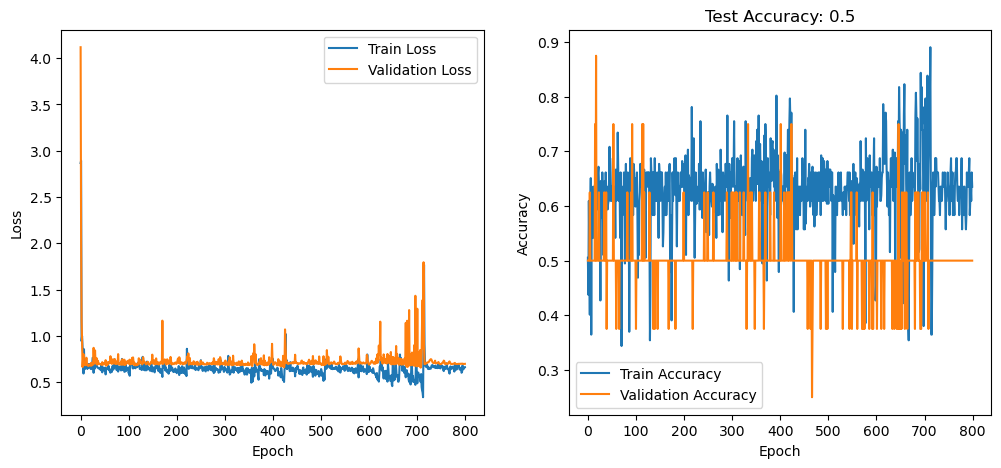

/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Max Valid Accuracy,▁███████████████████████████████████████
Test Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▅▆▄▄▆▅▅▆▆▄▅▆▆▆▄▅▇▆▅▆▆▄▅▅▅▄▆▄▇▅▂▄▇█▅▅▅▅
Train Loss,█▅▅▅▆▆▅▅▅▄▄▅▅▅▄▄▅▄▄▄▅▅▅▆▅▅▅▆▄▅▃▄▆▅▃▁▅▅▅▅
Validation Accuracy,▅█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▁▁▅▅▅▅█▅▅▅▅▅
Validation Loss,▁▁▁▂▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁█▁▁▁▁
Max Valid Accuracy,0.875
Test Accuracy,0.5
Train Accuracy,0.63542
Train Loss,0.66245
Validation Accuracy,0.5


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Epoch 1/800
Train Loss: 3.2782, Validation Loss: 1.2071
Train Accuracy: 0.4688, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 2/800
Train Loss: 1.1542, Validation Loss: 0.8923
Train Accuracy: 0.5521, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 3/800
Train Loss: 0.6815, Validation Loss: 0.8701
Train Accuracy: 0.6458, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 4/800
Train Loss: 0.9634, Validation Loss: 1.1320
Train Accuracy: 0.4271, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 5/800
Train Loss: 1.0236, Validation Loss: 0.7102
Train Accuracy: 0.6615, Validation Accuracy: 0.3750
Max Validation Accuracy: 0.5000
Epoch 6/800
Train Loss: 0.7011, Validation Loss: 0.7146
Train Accuracy: 0.5208, Validation Accuracy: 0.3750
Max Validation Accuracy: 0.5000
Epoch 7/800
Train Loss: 0.7801, Validation Loss: 0.7202
Train Accuracy: 0.6250, Validation Accuracy: 0.5000
Max Validation Accuracy: 0.5000
Epoch 8/800
Train Lo

/Users/mathilde/Documents/Bachelor-Thesis-Alzheimers-HGNN/functions.py:449: DeprecationWarning: invalid escape sequence '\m'
  """The hypergraph convolutional operator from the `"Hypergraph Convolution


KeyboardInterrupt: 

In [10]:
# Doing some parameter gridsearch to find the best hyperparameters
from sklearn.model_selection import ParameterGrid

# Building the graphs
threshold = 0.5
age = False
sex = False
matrixprofile = True
weight = True
if matrixprofile:
    in_channels = 461 + int(age) + int(sex)
else:
    in_channels = 5 + int(age) + int(sex)
method = 'pearson'

root = f'Raw_to_graph_2Class/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = Raw_to_Graph_2Class(root=root, threshold=threshold, method=method, weight=weight, sex=sex, age=age, matrixprofile=matrixprofile)
f.dataset_features_and_stats(dataset, diagnostic_label)

# Creating the train, validation and test sets
train_loader, valid_loader, test_loader, nbr_classes = f.create_train_test_valid(dataset)

param_grid = {
    'learning_rate': [0.001, 0.0001],
    'hidden_channels': [128, 64],
    'num_layers': [3, 2, 1],
    'dropout_rate': [0.2, 0.1, 0.0],
    'weight_decay': [0.001, 0.0001]
}
# param_grid = {
#     'learning_rate': [0.0001, 0.001],
#     'hidden_channels': [64, 128],
#     'num_layers': [1, 2, 3],
#     'dropout_rate': [0.0, 0.1, 0.2],
#     'weight_decay': [0.0001, 0.001]
# }


# Create combinations of hyperparameters
param_combinations = ParameterGrid(param_grid)
n_epochs = 800
# Train using each combination
for params in param_combinations:
    if matrixprofile:
        filename = f'2Class_Models/GCN_Models_MP/threshold_{threshold}/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_wdecay{params["weight_decay"]}_w{weight}.png'
    else:
        filename = f'2Class_Models/GCN_Models/threshold_{threshold}/lr{params["learning_rate"]}_hc{params["hidden_channels"]}_nl{params["num_layers"]}_d{params["dropout_rate"]}_epochs{n_epochs}_wdecay{params["weight_decay"]}_w{weight}.png'
    if os.path.exists(filename):
        pass
    else:
        parameters = [params['learning_rate'], params['hidden_channels'], params['num_layers'], params['dropout_rate']]
        model = m.GCN(in_channels=in_channels, hidden_channels=parameters[1], out_channels=nbr_classes, num_layers=parameters[2], dropout=parameters[3], nbr_classes=nbr_classes)
        criterion = torch.nn.CrossEntropyLoss()
        if 'weight_decay' not in params.keys():
            w_decay = 0
        else:
            w_decay = params['weight_decay']
        optimizer = torch.optim.Adam(model.parameters(), lr=parameters[0], weight_decay=w_decay)
        train_losses, train_accuracies, valid_losses, valid_accuracies, max_valid_accuracy, test_accuracy = m.train_GCN(model, optimizer, criterion, w_decay, threshold, train_loader, valid_loader, parameters, test_loader, testing=True, n_epochs=800)